In [1]:
import random
import torch
import time
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from unityagents import UnityEnvironment

from ddpg_agent import Agent

In [2]:
# Load Reacher enrvironment
env = UnityEnvironment(file_name='Reacher_Linux_NoVis/Reacher')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# Reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# Number of agents
num_agents = len(env_info.agents)
print("Number of agents: ", num_agents)

# Size of each action
action_size = brain.vector_action_space_size
print("Size of each action: ", action_size)

# Examine the state space
states = env_info.vector_observations
state_size = states.shape[1]
print(f"There are {states.shape[0]} agents. Each observes a state with length: {state_size}")
print(f"The state for the first agent looks like: {states[0]}")

Number of agents:  20
Size of each action:  4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [9]:
random_seed = 2019
train_mode = True

agent = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed)

def train_ddpg(n_episodes=2000, max_t=1000, print_every=10, learn_every=20, num_learn=10, goal_score=30):
    total_scores_deque = deque(maxlen=100)
    total_scores = []
    
    for i_episode in range(1, n_episodes+1):
        # Reset env and agent
        env_info = env.reset(train_mode=train_mode)[brain_name]
        
        # Get the current state for each agent
        states = env_info.vector_observations
        
        # Initialize the score for each agent
        scores = np.zeros(num_agents)
        agent.reset()
        
        start_time = time.time()
        
        for t in range(max_t):
            actions = agent.act(states)
            
            # Send all actions to the environment
            env_info = env.step(actions)[brain_name]
            
            # Get next state (for each agent)
            next_states = env_info.vector_observations
            
            # Get reward (for each agent)
            rewards = env_info.rewards
            
            # See if episode finished
            dones = env_info.local_done
            
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                # Send actions to the agent
                agent.step(state, action, reward, next_state, done)
                
            # Update score for each agent
            scores += env_info.rewards
            
            # Roll over states to next time step
            states = next_states
            
            if t % learn_every == 0:
                for _ in range(num_learn):
                    agent.start_learn()
            # Exit loop if episode finished
            if np.any(dones):
                break
                
        mean_score = np.mean(scores)
        min_score = np.min(scores)
        max_score = np.max(scores)
        total_scores_deque.append(mean_score)
        total_scores.append(mean_score)
        total_average_score = np.mean(total_scores_deque)
        duration = time.time() - start_time
        
        print('\rEpisode {}\tTotal Average Score: {:.2f}\tMean: {:.2f}\tMin: {:.2f}\tMax: {:.2f}\tDuration: {:.2f}'
              .format(i_episode, total_average_score, mean_score, min_score, max_score, duration))
        
        if i_episode % print_every == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tTotal Average Score: {:.2f}'.format(i_episode, total_average_score))
            
        
        if total_average_score >= goal_score and i_episode >= 100:
            print('Problem Solved after {} epsisodes!! Total Average score: {:.2f}'.format(i_episode, total_average_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return total_scores

In [10]:
scores = train_ddpg()

Episode 1	Total Average Score: 0.30	Mean: 0.30	Min: 0.00	Max: 0.85	Duration: 7.87
Episode 2	Total Average Score: 0.21	Mean: 0.11	Min: 0.00	Max: 0.56	Duration: 8.28
Episode 3	Total Average Score: 0.16	Mean: 0.08	Min: 0.00	Max: 0.24	Duration: 8.48
Episode 4	Total Average Score: 0.22	Mean: 0.40	Min: 0.02	Max: 1.33	Duration: 8.71
Episode 5	Total Average Score: 0.35	Mean: 0.87	Min: 0.17	Max: 1.72	Duration: 8.94
Episode 6	Total Average Score: 0.50	Mean: 1.21	Min: 0.18	Max: 2.81	Duration: 9.17
Episode 7	Total Average Score: 0.61	Mean: 1.31	Min: 0.13	Max: 2.81	Duration: 9.41
Episode 8	Total Average Score: 0.70	Mean: 1.33	Min: 0.10	Max: 3.32	Duration: 9.74
Episode 9	Total Average Score: 0.74	Mean: 1.03	Min: 0.20	Max: 2.79	Duration: 10.20
Episode 10	Total Average Score: 0.82	Mean: 1.60	Min: 0.45	Max: 4.17	Duration: 10.54
Episode 10	Total Average Score: 0.82
Episode 11	Total Average Score: 0.94	Mean: 2.13	Min: 0.67	Max: 4.21	Duration: 10.95
Episode 12	Total Average Score: 1.04	Mean: 2.16	Min: 1.1

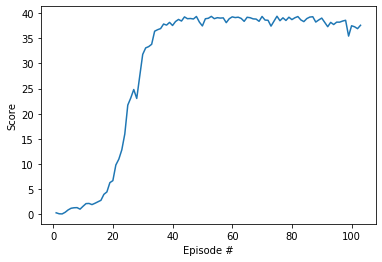

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()